# Filamentation Plasma 3

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from lens import ray
from lens import design
import matplotlib.pyplot as plt
from ionization import adk
from scipy.interpolate import interp1d
from scipy.optimize import newton
from copy import copy
import matplotlib.colors as colors
import numpy.ma as ma
from copy import copy
plt.style.use('presentation')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Filamentation/FP_3/'
lam = 0.8
tau = 70.

Filamentation plasma simulation using the gas jet profile from UCLA and including beam dump simulations.

In [2]:
def plot_laser_plasma(I, ne, ext, name=None):
    plt.figure(figsize=(16, 4), dpi=300)
    plt.subplot(121)
    plt.imshow(np.flipud(np.transpose(I)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (mm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)

    plt.subplot(122)
    plt.imshow(np.flipud(np.transpose(ne)), aspect='auto', extent=ext, cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
    plt.xlabel('$z$ (mm)')
    plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)
    plt.tight_layout()
    if name is not None:
        plt.savefig(path+name+'.png')
    plt.show()

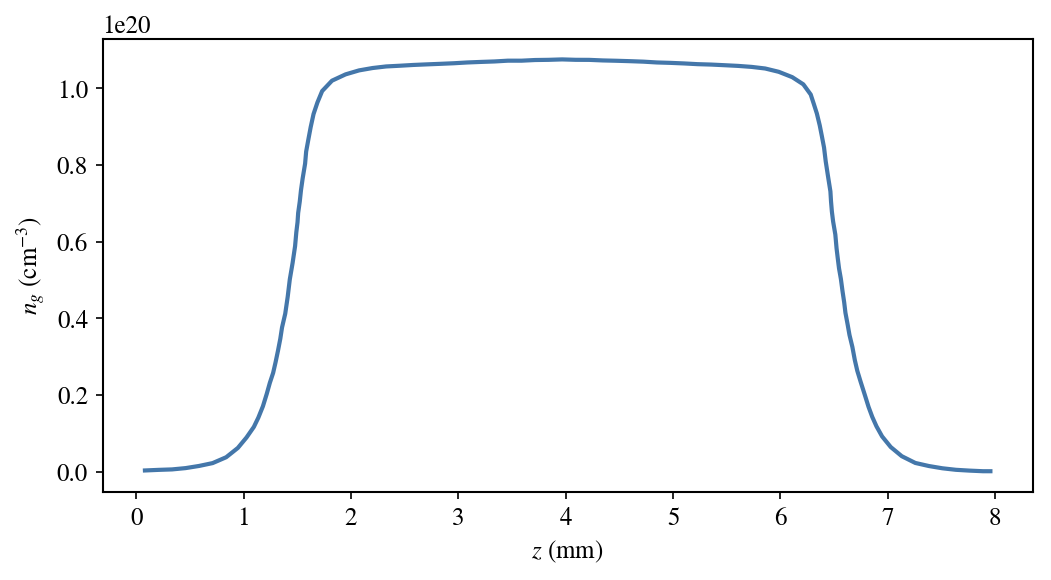

In [3]:
# Load the gas jet profile from a csv file
plt.figure(figsize=(8, 4), dpi=150)
jet_data = np.genfromtxt(path+"1mmX5mm_Filamentation_Jet_Profile.csv", delimiter=',')
n_jet = interp1d(jet_data[:, 0]*1e3, jet_data[:, 1]*1e19, fill_value=0.0, bounds_error=False)
plt.plot(jet_data[:, 0], jet_data[:, 1]*1e19)
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$n_g$ ($\mathrm{cm^{-3}}$)')
plt.show()

In [4]:
def ionize_jet(energy, w0, z0, n0, atom, temp, Nx, X, Nz, Z, plot=True, suffix=None, n2=0.0):
    name = "Energy=%0.2fmJ_w0=%0.1fum_z0=%0.2fmm_n0=%0.2E_T=%0.0feV" % (energy*1e3, w0, z0*1e-3, n0, temp)
    if suffix is None:
        suffix = ''
    name += suffix
    z = np.linspace(0, Z, Nz)
    pulseParams = {
        'Nt' : 2**6,
        'Nx' : Nx,
        'Ny' : Nx,
        'X' : X,
        'Y' : X,
        'T' : 3*tau,
        'lam' : lam,
        'path' : path,
        'load' : False,
        'threads' : 20,
        'cyl' : True,
        'tau' : tau,
        'z0' : z0,
        'name' : name+'_Beam',
        'E0' : 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9,
        'waist' : w0
    }

    ext = [z[0]/1e3, z[-1]/1e3, -X/2, X/2]
    beam = laserbeam.GaussianLaser(pulseParams)
    if plot:
        beam.plot_current_intensity()
    beam.propagate(z-z[0], 1.0)
    e = np.zeros((Nz, Nx), dtype='complex128')
    for i in range(Nz):
        e[i, :] = beam.load_field(i+1)[0]
        
    n = np.ones((Nx, Nx, Nz), dtype='double')
    n = n * n_jet(z)[None, None, :]
    n_slice = np.transpose(n[:, int(Nx/2), :])

    ne = n_slice*adk.gaussian_frac(atom['EI'], abs(e), tau, atom['Z'], atom['l'])
    I = beam.intensity_from_field(e)
    if plot:
        plot_laser_plasma(I, ne, ext, name+'_beam')
    
    pulseParams['name'] = name + '_Pulse'
    plasmaParams = {
        'Nx' : Nx,
        'Ny' : Nx,
        'Nz' : Nz,
        'X' : X,
        'Y' : X,
        'Z' : Z,
        'atom' : atom,
        'path' : path,
        'load' : False,
        'cyl' : True,
        'name' : name+'_Plasma',
        'n0' : n0/1e17
    }
    pulse = laserpulse.GaussianPulse(pulseParams)
    print('Initial pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
    ext = [z[0]/1e3, z[-1]/1e3, -X/2, X/2]
    hydrogen = plasma.Plasma(plasmaParams)

    # Initialize gas density
    ne = np.zeros((Nx, Nx, Nz), dtype='double')
    hydrogen.initialize_plasma(n/1e17, ne)

    interactions.pulse_plasma_energy(pulse, hydrogen, temp, n2)
    print('Final pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
    e = np.zeros((Nz, Nx), dtype='complex128')
    ne = np.zeros((Nz, Nx))
    for i in range(0, Nz-1):
        ne[i, :] = hydrogen.load_plasma_density(i)[0]
    for i in range(Nz):
        e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
    I = ionization.intensity_from_field(e)
    ne = ne*1e17
    plot_laser_plasma(I, ne, ext, name+'_pulse')
    return pulse

In [5]:
energy = 100e-3
w0 = 15
Nx = 2**8
X = 500
Nz = 800
Z = 8e3
z0 = -7e3
n0 = 1e20
atom = ionization.H2
temp = 20
#pulse = ionize_jet(energy, w0, z0, n0, atom, temp, Nx, X, Nz, Z, n2=1e-19)

In [6]:
def prep_ma(Z, X, Nzi, Zi, Z0i, Xi, Nxi, array):
    
    # Calculate the size of the extended array
    Nx = int(Nxi*X/Xi)
    Nz = int(Nzi*Z/Zi)
    # Extend the array to fill the entire imshow with the correct spacing
    Im = np.zeros((Nx, Nz))
    Im = ma.asarray(Im)
    # Mark the entire array as invalid
    Im[:, :] = ma.masked
    # Fill in the intensity 
    Nx0 = int((Nx-Nxi)/2)
    Nz0 = int(Nzi*Z0i/Zi)
    Im[Nx0:Nx0+Nxi, Nz0:Nz0+Nzi] = array
    return Im

In [7]:
Z = 2.5e6
n = 8
w0 = 24e3
Nx_in = 2**13
X_in = 60e3
Nz_in = 256
f = 1.25e6
z_end = 7e3
beamParams = {'Nx' : Nx_in,
              'Ny' : Nx_in,
              'X' : X_in,
              'Y' : X_in,
              'lam' : lam,
              'path' : path,
              'name' : 'Input_beam1',
              'threads' : 20,
              'cyl' : True,
              'load' : False,
              'E0' : 1.0,
              'waist' : w0,
              'order' : n}

# Super Gaussian for simulation
beam_in = laserbeam.SuperGaussianLaser(beamParams)
lensParams = {'Nx' : Nx_in,
              'Ny' : Nx_in,
              'X' : X_in,
              'Y' : X_in,
              'path' : path,
              'name' : 'Spherical_Lens',
              'lam' : lam,
              'f' : f,
              'load' : False}
lens = optic.SphericalLens(lensParams)
interactions.beam_phase(beam_in, lens)
z_in = np.linspace(0, f/2, Nz_in)
beam_in.propagate(z_in, 1)
I_in = np.zeros((Nz_in, Nx_in))
for i in range(Nz_in):
    I_in[i, :] = beam_in.intensity_from_field(beam_in.load_field(i+1)[0])
I_in = beam_in.prep_data(I_in)

Im = {}
X = X_in
ext0 = [0, Z, -X_in/1e3, X_in/1e3]
Im[0] = prep_ma(Z, X, Nz_in, f/2, 0.0, X, Nx_in, I_in)
start = f/2
beam_o = beam_in


M = 3
for i in range(1, M):
    multi = 2**i
    beamParams['X'] = X_in/multi
    beamParams['Y'] = X_in/multi
    beamParams['name'] = 'Input_beam%i' % i
    beam_n = laserbeam.Laser(beamParams)
    e = beam_n.reconstruct_from_cyl_beam(beam_o)
    beam_n.initialize_field(e)
    Nz_n = int(Nz_in/multi)
    if i == M-1:
        Nz_n = 2*Nz_n
        z_n = np.linspace(0, f/multi-z_end, Nz_n)
    else:
        z_n = np.linspace(0, f/(2*multi), Nz_n)
    beam_n.propagate(z_n, 1)
    I_n = np.zeros((Nz_n, Nx_in))
    for j in range(Nz_n):
        I_n[j, :] = beam_n.intensity_from_field(beam_n.load_field(j+1)[0])
    I_n = beam_n.prep_data(I_n)
    length = z_n[-1]
    Im[i] = prep_ma(Z, X, Nz_n, length, start, X_in/multi, Nx_in, I_n)
    start = length+start
    beam_o = beam_n

In [11]:
Nx = 2**8
Xp = 500
Nz = 800
Zp = 8e3
n0 = 1e20
atom = ionization.H2
temp = 20
n2 = 1e-19
z = np.linspace(0, Zp, Nz)
pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : Xp,
    'Y' : Xp,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'name' : 'Refracted_Pulse',
    'E0' : 1.0
}
n = np.ones((Nx, Nx, Nz), dtype='double')
n = n * n_jet(z)[None, None, :]

plasmaParams = {
    'Nx' : Nx,
    'Ny' : Nx,
    'Nz' : Nz,
    'X' : Xp,
    'Y' : Xp,
    'Z' : Zp,
    'atom' : atom,
    'path' : path,
    'load' : False,
    'cyl' : True,
    'name' : 'Refracted_Plasma',
    'n0' : n0/1e17
}
pulse = laserpulse.Pulse(pulseParams)
t = pulse.t
e = pulse.reconstruct_from_cyl_beam(beam_o)*np.exp(-t[:, None, None]**2*np.pi/(2*pulse.tau**2))
pulse.initialize_field(e)
print('Initial pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
hydrogen = plasma.Plasma(plasmaParams)

# Initialize gas density
ne = np.zeros((Nx, Nx, Nz), dtype='double')
hydrogen.initialize_plasma(n/1e17, ne)

interactions.pulse_plasma_energy(pulse, hydrogen, temp, n2)
print('Final pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
e = np.zeros((Nz, Nx), dtype='complex128')
ne = np.zeros((Nz, Nx))
for i in range(0, Nz-1):
    ne[i, :] = hydrogen.load_plasma_density(i)[0]
for i in range(Nz):
    e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
I = ionization.intensity_from_field(e)
ne = ne*1e17

Initial pulse energy 127.95mJ
Final pulse energy 71.30mJ


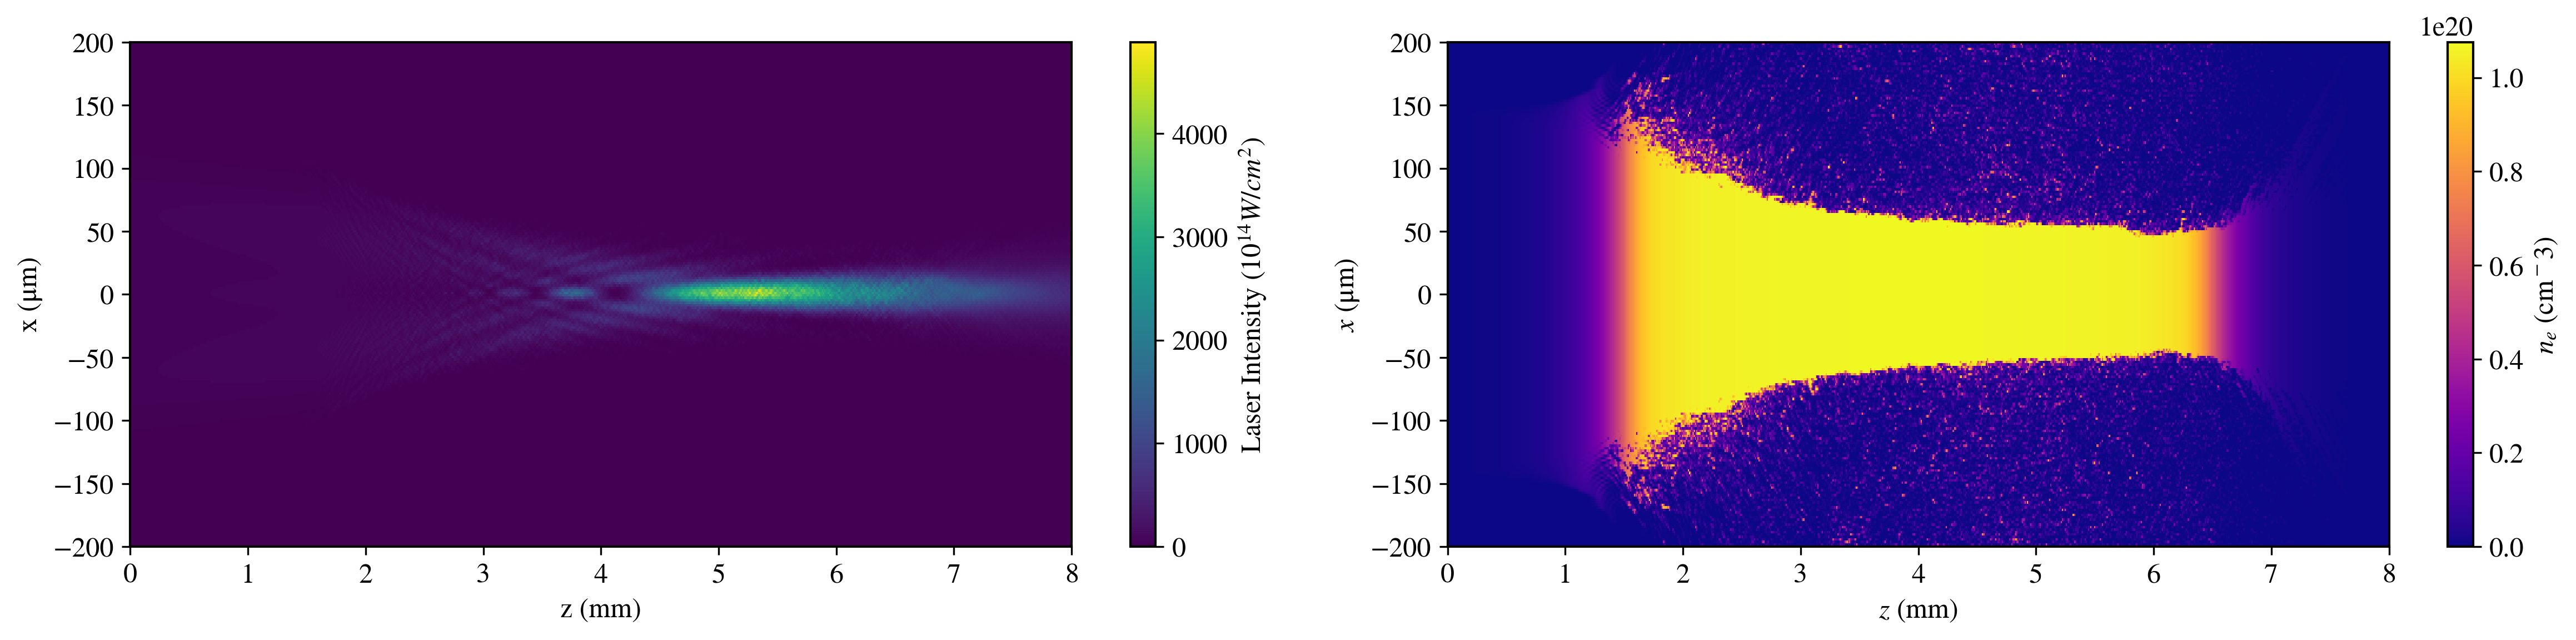

In [ ]:
plot_laser_plasma(I, ne, [z[0]/1e3, z[-1]/1e3, -Xp/2, Xp/2], 'Refracted_Pulse')

In [32]:
Nx_out = 2**11
X_out = 20e3
Nz_out = 100
z_start = 3e3
Z_out = 300e3
I_out = design.propagate_down_beampipe(pulse, [Z_out], [X_out], X_out, Nx_out, Nz_out)
Im[M], pulse_out = prep_ma(Z, X, Nz_out, Z_out, f+z_start, X_out, Nx_out, I_out, ret_pulse=True)
start = f + z_start + Z_out

m = 3.
I_out= design.propagate_down_beampipe(pulse_out, [Z_out*m], [X_out*m], X_out*m, Nx_out, int(Nz_out*m))
Im[M+1] = prep_ma(Z, X, int(Nz_out*m), Z_out*m, start, X_out*m, Nx_out, I_out)
start1 = start + Z_out*m

TypeError: prep_ma() got an unexpected keyword argument 'ret_pulse'

In [ ]:
ext0 = [0, Z/1e3, -X_in/1e3, X_in/1e3]

plt.figure(figsize=(8.5, 4), dpi=300)
palette = copy(plt.cm.gist_ncar_r)
palette.set_bad('w', 0.0)
palette.set_under('w', 1.0)
norm = colors.LogNorm(vmin=1e9, vmax=5e13)
for i in range(M+2):
    plt.imshow(Im[i]*1e14, aspect='auto', extent=ext0, norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($\mathrm{W/cm^2}$)')
plt.set_cmap(palette)
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
#plt.ylim(-20e3, 20e3)
plt.xlim(0, 2125)

# USHM
dz = 425
L = 0
plt.plot([L/1e3+dz, L/1e3+dz], [-50.8, -2.5], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [50.8, 2.5], 'k-', lw=1)
plt.text(320, 53, 'USHM')
# Bypass line
w = 41.1
dz = 1492.7
l = 200.4
plt.plot([L/1e3+dz, L/1e3+dz], [-w/2, -60], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [60, w/2], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [-w/2, -w/2], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [w/2, w/2], 'k-', lw=1)
plt.text(1500, 22, 'B1')

w2 = 31.8
dz = 1693.1
l = 1000
plt.plot([L/1e3+dz, L/1e3+dz], [-w2/2, -w/2], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [w/2, w2/2], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [-w2/2, -w2/2], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [w2/2, w2/2], 'k-', lw=1)
plt.text(1720, 17, 'B2')

plt.show()